# DS-SF-23 Final Project
### [Predicting Airbnb bookings](https://docs.google.com/presentation/d/1FVTTS478OCozncuxhWlaJr5ZkUGrMPHfKJ6uLm4Hsuw/edit?usp=sharing)
Vanessa Grass, July 12th 2016

______________________________________________________________________________________________________________________

# Part 4: Modeling Performance
Below I attempt to discover features which may have a relationship to first booking. My strategy is to take each variable, convert to binary via dummy variables (if categorical, which all of 16 but age are). Then create appropriate plots to uncover additional insights. And finally create a correlation matrix and take a sneak peek at OLS regression results.

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model, cross_validation

# pd.set_option('display.max_rows', 10)
# pd.set_option('display.notebook_repr_html', True)
# pd.set_option('display.max_columns', 999)

%matplotlib inline
plt.style.use('ggplot')

## Import Data 

In [2]:
#import dataset
users = pd.read_csv(os.path.join('datasets', 'airbnb_clean_2.csv'))
users.drop(["id", "account", "active", "booked", "active_to_booked"], axis=1, inplace=True)
# users.head(3)

## Feature Selection

#### Checking days relationship with the only other continuous variable (age)

In [3]:
#checking correlation between age & days... hm really low
users[ ['age', 'days'] ].corr()

age    days
age   1.0000 -0.0143
days -0.0143  1.0000

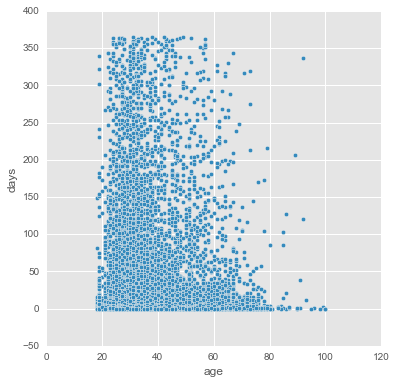

In [4]:
#this plot is not linear at all... doesn't really show much of a relationship between days & age
users.plot('age', 'days', kind = 'scatter', figsize = (6, 6))

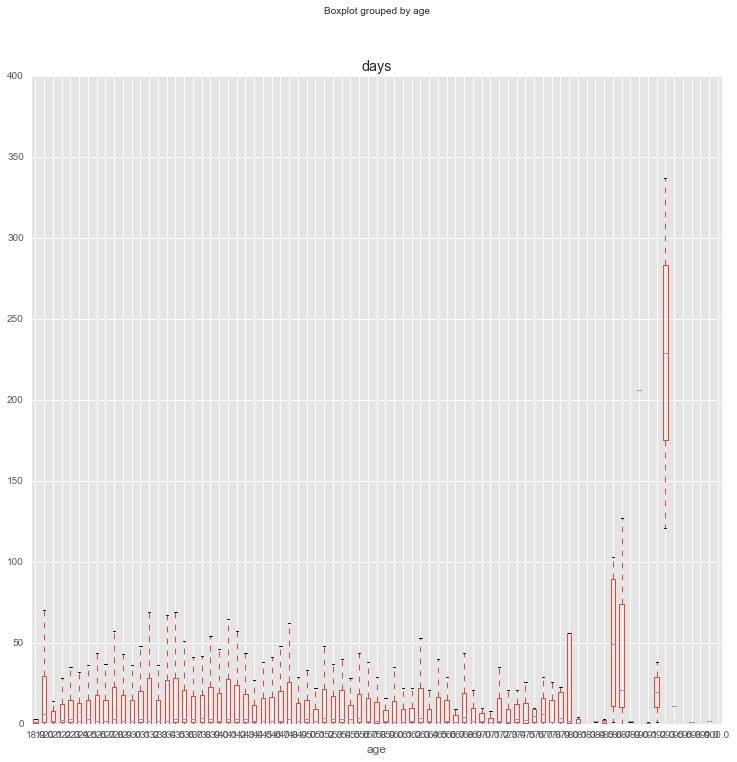

In [5]:
#just curious what this would look like
users.boxplot('days', by = 'age', figsize = (12, 12))

In [6]:
#wow zero for R-squared! not starting on a high note :(
smf.ols(formula = 'days ~ age', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.172
Date:                Tue, 12 Jul 2016   Prob (F-statistic):             0.0750
Time:                        03:02:47   Log-Likelihood:                -86829.
No. Observations:               15508   AIC:                         1.737e+05
Df Residuals:                   15506   BIC:                         1.737e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     32.5638      1.682     19.356      0.000        29.266    35.861
age           -0.0773      0.043     -1.781      0.075        -0.162     0.008
==============================================================================
Omnibus:                     9426.294   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72495.919
Skew:                           2.970   Prob(JB):                         0.00
Kurtosis:                      11.770   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Binning age data
Not that hopeful it'll make a difference but just for the sake of learning/practice I'll try segmented age in categories

In [7]:
bins = [18, 29, 49, 64, 100]

In [8]:
group_names = ['18-29', '30-49', '50-64', '65-100']

In [9]:
age_groups = pd.cut(users['age'], bins, labels=group_names)
users['age_groups'] = pd.cut(users['age'], bins, labels=group_names)
users.age_groups.value_counts()

30-49     8008
18-29     4983
50-64     1952
65-100     535
dtype: int64

#### Double checking bins are correct

In [10]:
sum((users.age > 18)&(users.age < 30))

4983

In [11]:
sum((users.age > 29)&(users.age < 50))

8008

In [12]:
sum((users.age > 49)&(users.age < 65))

1952

In [13]:
sum((users.age > 64)&(users.age < 101))

535

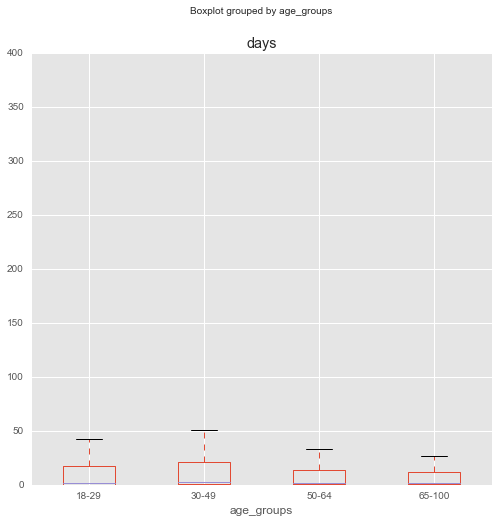

In [14]:
#well atleast this *looks* cleaner
users.boxplot('days', by = 'age_groups', figsize = (8, 8))

# Dummy variables

#### Age
Convert binned age data into dummy variables

In [15]:
users_age_groups = pd.get_dummies(users.age_groups, prefix = 'ages')

In [16]:
users_age_groups.rename(columns={'ages_18-29': 'age_a',
                        'ages_30-49': 'age_b','ages_50-64': 'age_c','ages_65-100': 'age_d'}, inplace = True)

In [17]:
users_age_groups.columns

Index([u'age_a', u'age_b', u'age_c', u'age_d'], dtype='object')

In [18]:
users = users.join([users_age_groups])

In [19]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d'],
      dtype='object')

In [20]:
# ever so slightly better 
users[ ['age_a', 'age_b', 'age_c', 'age_d','days'] ].corr()

age_a     age_b     age_c     age_d      days
age_a  1.000000 -0.710994 -0.261101 -0.130064 -0.024091
age_b -0.710994  1.000000 -0.392108 -0.195323  0.043867
age_c -0.261101 -0.392108  1.000000 -0.071729 -0.016023
age_d -0.130064 -0.195323 -0.071729  1.000000 -0.026167
days  -0.024091  0.043867 -0.016023 -0.026167  1.000000

In [21]:
#well R-squared not zero this time... but it's pretty close to it haha
smf.ols(formula = 'days ~ age_a + age_b + age_c + age_d', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.265
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           1.79e-07
Time:                        03:02:48   Log-Likelihood:                -86812.
No. Observations:               15508   AIC:                         1.736e+05
Df Residuals:                   15503   BIC:                         1.737e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.0667     11.924      0.844      0.399       -13.305    33.438
age_a         17.3618     11.959      1.452      0.147        -6.080    40.804
age_b         22.4261     11.946      1.877      0.060        -0.989    45.841
age_c         16.8903     12.015      1.406      0.160        -6.660    40.441
age_d         10.6006     12.253      0.865      0.387       -13.417    34.619
==============================================================================
Omnibus:                     9397.079   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71873.429
Skew:                           2.960   Prob(JB):                         0.00
Kurtosis:                      11.728   Cond. No.                         60.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
smf.ols(formula = 'days ~ age_b', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.90
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           4.63e-08
Time:                        03:02:48   Log-Likelihood:                -86816.
No. Observations:               15508   AIC:                         1.736e+05
Df Residuals:                   15506   BIC:                         1.737e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     26.7540      0.754     35.473      0.000        25.276    28.232
age_b          5.7388      1.050      5.468      0.000         3.681     7.796
==============================================================================
Omnibus:                     9399.693   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71908.299
Skew:                           2.961   Prob(JB):                         0.00
Kurtosis:                      11.730   Cond. No.                         2.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Gender
Convert gender into dummy variables

In [23]:
users.gender.value_counts()

FEMALE    8575
MALE      6895
OTHER       38
Name: gender, dtype: int64

In [24]:
#decided to get rid of other after all... maybe not very PC of me but trying to simplify things
users = users[users.gender !='OTHER']

users.gender.value_counts()

FEMALE    8575
MALE      6895
Name: gender, dtype: int64

In [25]:
dummy_gender = pd.get_dummies(users.gender, prefix = 'Gender')

In [26]:
dummy_gender.head(3)

Gender_FEMALE  Gender_MALE
0            1.0          0.0
1            0.0          1.0
2            1.0          0.0

In [27]:
users = users.join([dummy_gender])

In [28]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE'],
      dtype='object')

In [29]:
#again correlation is very low here
users[ ['Gender_MALE','days'] ].corr()

Gender_MALE      days
Gender_MALE     1.000000 -0.037687
days           -0.037687  1.000000

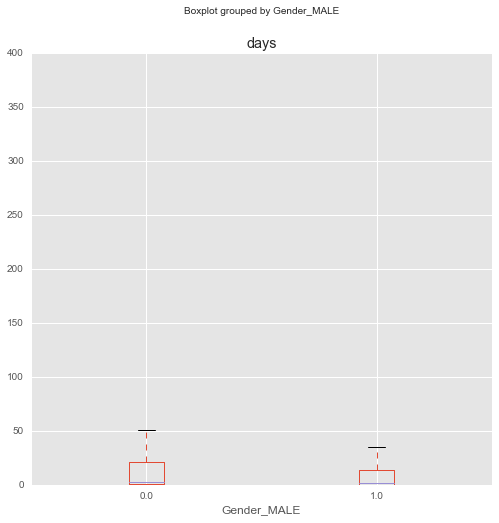

In [30]:
users.boxplot('days', by = 'Gender_MALE', figsize = (8, 8))

In [31]:
# R-squared, ugh!
smf.ols(formula = 'days ~ Gender_MALE', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.00
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           2.75e-06
Time:                        03:02:49   Log-Likelihood:                -86591.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      31.8596      0.705     45.204      0.000        30.478    33.241
Gender_MALE    -4.9517      1.056     -4.690      0.000        -7.021    -2.882
==============================================================================
Omnibus:                     9412.611   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72638.988
Skew:                           2.972   Prob(JB):                         0.00
Kurtosis:                      11.796   Cond. No.                         2.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Signup method
converting signup method into dummy variables

In [32]:
users.signup_method.value_counts()

basic       9478
facebook    5992
Name: signup_method, dtype: int64

In [33]:
dummy_signup_method = pd.get_dummies(users.signup_method, prefix = 'signup')

In [34]:
dummy_signup_method.head(2)

signup_basic  signup_facebook
0           0.0              1.0
1           1.0              0.0

In [35]:
users = users.join([dummy_signup_method])

In [36]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook'],
      dtype='object')

In [37]:
#so low! :(
users[ ['signup_basic', 'days'] ].corr()

signup_basic      days
signup_basic      1.000000 -0.065527
days             -0.065527  1.000000

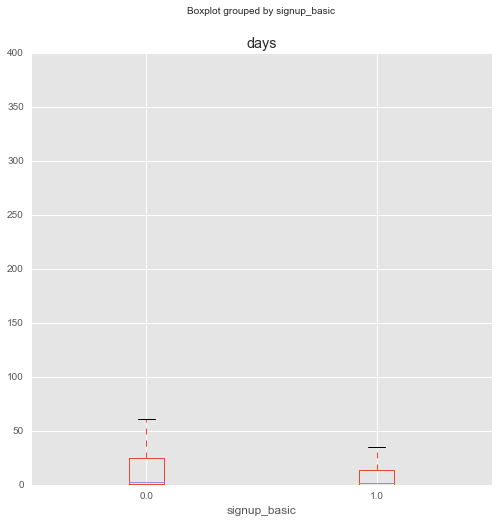

In [38]:
users.boxplot('days', by = 'signup_basic', figsize = (8, 8))

In [39]:
# R-squared is slighty better than previous features
smf.ols(formula = 'days ~ signup_basic', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     66.70
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           3.40e-16
Time:                        03:02:49   Log-Likelihood:                -86568.
No. Observations:               15470   AIC:                         1.731e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       35.0347      0.842     41.613      0.000        33.384    36.685
signup_basic    -8.7847      1.076     -8.167      0.000       -10.893    -6.676
==============================================================================
Omnibus:                     9382.501   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72076.430
Skew:                           2.961   Prob(JB):                         0.00
Kurtosis:                      11.760   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Signup flow
converting signup flow into dummy variables

In [40]:
#hm what to do here
users.signup_flow.value_counts()

0     14693
12      267
24      218
25      209
21       44
23       21
8        17
20        1
Name: signup_flow, dtype: int64

In [41]:
#whelp gonna give dummy variables a try even though doesn't seem very promising
dummy_signup_flow = pd.get_dummies(users.signup_flow, prefix = 'signup_flow')


In [42]:
dummy_signup_flow.columns

Index([u'signup_flow_0', u'signup_flow_8', u'signup_flow_12',
       u'signup_flow_20', u'signup_flow_21', u'signup_flow_23',
       u'signup_flow_24', u'signup_flow_25'],
      dtype='object')

In [43]:
users = users.join([dummy_signup_flow])

In [44]:
#argh this aren't much better! but it's kinda weird how different signup flows are correlated?
users[ ['signup_flow_0', 'signup_flow_8', 'signup_flow_12', 'signup_flow_20', 
        'signup_flow_21', 'signup_flow_23', 'signup_flow_24', 'signup_flow_25', 'days'] ].corr()

signup_flow_0  signup_flow_8  signup_flow_12  signup_flow_20  \
signup_flow_0        1.000000      -0.144232       -0.576283       -0.034963   
signup_flow_8       -0.144232       1.000000       -0.004396       -0.000267   
signup_flow_12      -0.576283      -0.004396        1.000000       -0.001066   
signup_flow_20      -0.034963      -0.000267       -0.001066        1.000000   
signup_flow_21      -0.232244      -0.001771       -0.007078       -0.000429   
signup_flow_23      -0.160326      -0.001223       -0.004886       -0.000296   
signup_flow_24      -0.519888      -0.003965       -0.015844       -0.000961   
signup_flow_25      -0.508893      -0.003882       -0.015509       -0.000941   
days                -0.007060      -0.014134        0.020078       -0.002173   

                signup_flow_21  signup_flow_23  signup_flow_24  \
signup_flow_0        -0.232244       -0.160326       -0.519888   
signup_flow_8        -0.001771       -0.001223       -0.003965   
signup_flow_12       -0.007078       -0.004886       -0.015844   
signup_flow_20       -0.000429       -0.000296       -0.000961   
signup_flow_21        1.000000       -0.001969       -0.006385   
signup_flow_23       -0.001969        1.000000       -0.004408   
signup_flow_24       -0.006385       -0.004408        1.000000   
signup_flow_25       -0.006250       -0.004315       -0.013991   
days                  0.014856        0.000949       -0.000884   

                signup_flow_25      days  
signup_flow_0        -0.508893 -0.007060  
signup_flow_8        -0.003882 -0.014134  
signup_flow_12       -0.015509  0.020078  
signup_flow_20       -0.000941 -0.002173  
signup_flow_21       -0.006250  0.014856  
signup_flow_23       -0.004315  0.000949  
signup_flow_24       -0.013991 -0.000884  
signup_flow_25        1.000000 -0.011338  
days                 -0.011338  1.000000

In [45]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25'],
      dtype='object')

In [46]:
smf.ols(formula = 'days ~ signup_flow_12', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.238
Date:                Tue, 12 Jul 2016   Prob (F-statistic):             0.0125
Time:                        03:02:49   Log-Likelihood:                -86599.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         29.4789      0.530     55.664      0.000        28.441    30.517
signup_flow_12    10.0680      4.031      2.498      0.013         2.167    17.969
==============================================================================
Omnibus:                     9431.059   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73103.717
Skew:                           2.978   Prob(JB):                         0.00
Kurtosis:                      11.829   Cond. No.                         7.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
users.signup_flow.value_counts()

0     14693
12      267
24      218
25      209
21       44
23       21
8        17
20        1
Name: signup_flow, dtype: int64

In [48]:
users.signup_flow = np.where(users.signup_flow !=0, 'not-zero', 'zero')

In [49]:
users.signup_flow.value_counts()

zero        14693
not-zero      777
Name: signup_flow, dtype: int64

In [50]:
dummy_signup_flow = pd.get_dummies(users.signup_flow, prefix = 'signup_flow')

In [51]:
dummy_signup_flow.columns

Index([u'signup_flow_not-zero', u'signup_flow_zero'], dtype='object')

In [52]:
users = users.join([dummy_signup_flow])

In [53]:
users.head(3)

gender   age signup_method signup_flow language affiliate_channel  \
0  FEMALE  44.0      facebook        zero       en            direct   
1    MALE  47.0         basic        zero       en         sem-brand   
2  FEMALE  56.0      facebook        zero       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct                  linked        Web       Mac Desktop   
1             google           tracked-other        Web              iPad   
2             direct                  linked        Web       Mac Desktop   

         ...        signup_flow_0 signup_flow_8  signup_flow_12  \
0        ...                  1.0           0.0             0.0   
1        ...                  1.0           0.0             0.0   
2        ...                  1.0           0.0             0.0   

  signup_flow_20  signup_flow_21  signup_flow_23  signup_flow_24  \
0            0.0             0.0             0.0             0.0   
1            0.0             0.0             0.0             0.0   
2            0.0             0.0             0.0             0.0   

   signup_flow_25  signup_flow_not-zero  signup_flow_zero  
0             0.0                   0.0               1.0  
1             0.0                   0.0               1.0  
2             0.0                   0.0               1.0  

[3 rows x 32 columns]

In [54]:
users[ ['signup_flow_zero', 'days'] ].corr()

signup_flow_zero     days
signup_flow_zero           1.00000 -0.00706
days                      -0.00706  1.00000

In [55]:
smf.ols(formula = 'days ~ signup_flow_zero', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7711
Date:                Tue, 12 Jul 2016   Prob (F-statistic):              0.380
Time:                        03:02:50   Log-Likelihood:                -86601.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           31.6577      2.343     13.512      0.000        27.065    36.250
signup_flow_zero    -2.1111      2.404     -0.878      0.380        -6.823     2.601
==============================================================================
Omnibus:                     9425.567   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72928.731
Skew:                           2.976   Prob(JB):                         0.00
Kurtosis:                      11.815   Cond. No.                         8.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Language
converting language into dummy variables

In [56]:
users.language.value_counts()

en    15011
zh      101
fr       99
de       53
es       53
ko       43
ru       21
it       20
ja       19
pt       14
sv       11
no        6
da        5
nl        4
el        2
pl        2
tr        2
cs        1
fi        1
is        1
hu        1
Name: language, dtype: int64

In [57]:
users_lang = pd.get_dummies(users.language, prefix = 'lang')

In [58]:
users_lang.columns

Index([u'lang_cs', u'lang_da', u'lang_de', u'lang_el', u'lang_en', u'lang_es',
       u'lang_fi', u'lang_fr', u'lang_hu', u'lang_is', u'lang_it', u'lang_ja',
       u'lang_ko', u'lang_nl', u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru',
       u'lang_sv', u'lang_tr', u'lang_zh'],
      dtype='object')

In [59]:
users = users.join([users_lang])

In [60]:
#lang_fr

users[ ['lang_cs', 'lang_da','lang_de','lang_el','lang_en','lang_es','lang_fi','lang_fr','lang_hu',
        'lang_is', 'lang_it','days'] ].corr()

lang_cs   lang_da   lang_de   lang_el   lang_en   lang_es   lang_fi  \
lang_cs  1.000000 -0.000145 -0.000471 -0.000091 -0.045980 -0.000471 -0.000065   
lang_da -0.000145  1.000000 -0.001054 -0.000204 -0.102827 -0.001054 -0.000145   
lang_de -0.000471 -0.001054  1.000000 -0.000667 -0.335302 -0.003438 -0.000471   
lang_el -0.000091 -0.000204 -0.000667  1.000000 -0.065027 -0.000667 -0.000091   
lang_en -0.045980 -0.102827 -0.335302 -0.065027  1.000000 -0.335302 -0.045980   
lang_es -0.000471 -0.001054 -0.003438 -0.000667 -0.335302  1.000000 -0.000471   
lang_fi -0.000065 -0.000145 -0.000471 -0.000091 -0.045980 -0.000471  1.000000   
lang_fr -0.000645 -0.001443 -0.004705 -0.000913 -0.458950 -0.004705 -0.000645   
lang_hu -0.000065 -0.000145 -0.000471 -0.000091 -0.045980 -0.000471 -0.000065   
lang_is -0.000065 -0.000145 -0.000471 -0.000091 -0.045980 -0.000471 -0.000065   
lang_it -0.000289 -0.000647 -0.002110 -0.000409 -0.205754 -0.002110 -0.000289   
days     0.007183 -0.003924 -0.004363  0.000496 -0.002569  0.006563 -0.003528   

          lang_fr   lang_hu   lang_is   lang_it      days  
lang_cs -0.000645 -0.000065 -0.000065 -0.000289  0.007183  
lang_da -0.001443 -0.000145 -0.000145 -0.000647 -0.003924  
lang_de -0.004705 -0.000471 -0.000471 -0.002110 -0.004363  
lang_el -0.000913 -0.000091 -0.000091 -0.000409  0.000496  
lang_en -0.458950 -0.045980 -0.045980 -0.205754 -0.002569  
lang_es -0.004705 -0.000471 -0.000471 -0.002110  0.006563  
lang_fi -0.000645 -0.000065 -0.000065 -0.000289 -0.003528  
lang_fr  1.000000 -0.000645 -0.000645 -0.002887  0.010816  
lang_hu -0.000645  1.000000 -0.000065 -0.000289  0.002013  
lang_is -0.000645 -0.000065  1.000000 -0.000289 -0.003528  
lang_it -0.002887 -0.000289 -0.000289  1.000000  0.001514  
days     0.010816  0.002013 -0.003528  0.001514  1.000000

In [61]:
#lang_ja, lang_pt, lang_ru
users[ ['lang_ja', 'lang_ko', 'lang_nl', 'lang_no', 'lang_pl', 'lang_pt', 'lang_ru',
       'lang_sv', 'lang_tr', 'lang_zh','days'] ].corr()

lang_ja   lang_ko   lang_nl   lang_no   lang_pl   lang_pt   lang_ru  \
lang_ja  1.000000 -0.001851 -0.000564 -0.000691 -0.000399 -0.001055 -0.001293   
lang_ko -0.001851  1.000000 -0.000849 -0.001040 -0.000600 -0.001589 -0.001946   
lang_nl -0.000564 -0.000849  1.000000 -0.000317 -0.000183 -0.000484 -0.000593   
lang_no -0.000691 -0.001040 -0.000317  1.000000 -0.000224 -0.000593 -0.000726   
lang_pl -0.000399 -0.000600 -0.000183 -0.000224  1.000000 -0.000342 -0.000419   
lang_pt -0.001055 -0.001589 -0.000484 -0.000593 -0.000342  1.000000 -0.001110   
lang_ru -0.001293 -0.001946 -0.000593 -0.000726 -0.000419 -0.001110  1.000000   
lang_sv -0.000935 -0.001408 -0.000429 -0.000525 -0.000303 -0.000803 -0.000983   
lang_tr -0.000399 -0.000600 -0.000183 -0.000224 -0.000129 -0.000342 -0.000419   
lang_zh -0.002843 -0.004280 -0.001304 -0.001597 -0.000922 -0.002440 -0.002989   
days    -0.014340 -0.013237 -0.005825 -0.005324  0.006851  0.018528  0.010304   

          lang_sv   lang_tr   lang_zh      days  
lang_ja -0.000935 -0.000399 -0.002843 -0.014340  
lang_ko -0.001408 -0.000600 -0.004280 -0.013237  
lang_nl -0.000429 -0.000183 -0.001304 -0.005825  
lang_no -0.000525 -0.000224 -0.001597 -0.005324  
lang_pl -0.000303 -0.000129 -0.000922  0.006851  
lang_pt -0.000803 -0.000342 -0.002440  0.018528  
lang_ru -0.000983 -0.000419 -0.002989  0.010304  
lang_sv  1.000000 -0.000303 -0.002162 -0.005354  
lang_tr -0.000303  1.000000 -0.000922  0.006938  
lang_zh -0.002162 -0.000922  1.000000 -0.001425  
days    -0.005354  0.006938 -0.001425  1.000000

In [62]:
# grouping all non-english together did not yield better results
# users.language = np.where( users.language !='en', 'non-english', 'english' )
# users.language.value_counts()
# users_lang = pd.get_dummies(users.language, prefix = 'lang')
# users_lang.columns
# users = users.join([users_lang])
# users.columns
# users.columns
# users[ ['lang_english', 'lang_non-english', 'days'] ].corr()

<img src="language_binary.png">

In [63]:
smf.ols(formula = 'days ~ lang_fr + lang_ja + lang_pt ', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.433
Date:                Tue, 12 Jul 2016   Prob (F-statistic):             0.0162
Time:                        03:02:50   Log-Likelihood:                -86596.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15466   BIC:                         1.732e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     29.5922      0.527     56.129      0.000        28.559    30.626
lang_fr        8.8624      6.583      1.346      0.178        -4.042    21.767
lang_ja      -26.6448     14.989     -1.778      0.075       -56.024     2.735
lang_pt       40.2650     17.458      2.306      0.021         6.044    74.486
==============================================================================
Omnibus:                     9420.847   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72871.727
Skew:                           2.974   Prob(JB):                         0.00
Kurtosis:                      11.813   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Affiliate channel

In [64]:
users.affiliate_channel.value_counts()

direct           7065
sem-brand        4221
sem-non-brand    1917
seo              1259
other             536
api               253
content           143
remarketing        76
Name: affiliate_channel, dtype: int64

In [65]:
users.affiliate_channel = np.where(users.affiliate_channel !='direct', 'other', 'direct')

In [66]:
users.affiliate_channel.value_counts()

other     8405
direct    7065
Name: affiliate_channel, dtype: int64

In [67]:
dummy_affiliate_channel = pd.get_dummies(users.affiliate_channel, prefix = 'affiliate_channel')

In [68]:
users = users.join([dummy_affiliate_channel])

In [69]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other'],
      dtype='object')

In [70]:
users[ ['affiliate_channel_direct', 'days'] ].corr()

affiliate_channel_direct      days
affiliate_channel_direct                  1.000000  0.030296
days                                      0.030296  1.000000

In [71]:
smf.ols(formula = 'days ~ affiliate_channel_direct', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.21
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           0.000164
Time:                        03:02:50   Log-Likelihood:                -86595.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   27.8387      0.712     39.096      0.000        26.443    29.234
affiliate_channel_direct     3.9719      1.054      3.770      0.000         1.907     6.037
==============================================================================
Omnibus:                     9415.503   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72743.071
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      11.804   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Affiliate provider

In [72]:
users.affiliate_provider.value_counts()

direct             7065
google             6995
other               617
facebook            300
bing                220
padmapper           105
yahoo                57
vast                 40
gsp                  21
meetup               17
craigslist           12
email-marketing       8
naver                 6
baidu                 5
yandex                2
Name: affiliate_provider, dtype: int64

In [73]:
dummy_affiliate_provider = pd.get_dummies(users.affiliate_provider, prefix = 'affiliate_provider')

In [74]:
users = users.join([dummy_affiliate_provider])

In [75]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other',
       u'affiliate_provider_baidu', u'affiliate_pro

In [76]:
users[ ['affiliate_provider_direct', 'affiliate_provider_facebook', 'affiliate_provider_google',
        'affiliate_provider_other', 'days' ] ].corr()

affiliate_provider_direct  \
affiliate_provider_direct                     1.000000   
affiliate_provider_facebook                  -0.128930   
affiliate_provider_google                    -0.832935   
affiliate_provider_other                     -0.186863   
days                                          0.030296   

                             affiliate_provider_facebook  \
affiliate_provider_direct                      -0.128930   
affiliate_provider_facebook                     1.000000   
affiliate_provider_google                      -0.127759   
affiliate_provider_other                       -0.028662   
days                                            0.017989   

                             affiliate_provider_google  \
affiliate_provider_direct                    -0.832935   
affiliate_provider_facebook                  -0.127759   
affiliate_provider_google                     1.000000   
affiliate_provider_other                     -0.185165   
days                                         -0.057900   

                             affiliate_provider_other      days  
affiliate_provider_direct                   -0.186863  0.030296  
affiliate_provider_facebook                 -0.028662  0.017989  
affiliate_provider_google                   -0.185165 -0.057900  
affiliate_provider_other                     1.000000  0.030735  
days                                         0.030735  1.000000

In [77]:
smf.ols(formula = 'days ~ affiliate_provider_direct + affiliate_provider_google', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     34.20
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           1.52e-15
Time:                        03:02:50   Log-Likelihood:                -86568.
No. Observations:               15470   AIC:                         1.731e+05
Df Residuals:                   15467   BIC:                         1.732e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    39.4879      1.736     22.753      0.000        36.086    42.890
affiliate_provider_direct    -7.6773      1.901     -4.039      0.000       -11.403    -3.951
affiliate_provider_google   -13.9975      1.902     -7.358      0.000       -17.726   -10.268
==============================================================================
Omnibus:                     9389.652   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72405.251
Skew:                           2.962   Prob(JB):                         0.00
Kurtosis:                      11.788   Cond. No.                         7.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
users.affiliate_provider = np.where(users.affiliate_provider !='direct', 'other', 'direct')

In [79]:
users.affiliate_provider.value_counts()

other     8405
direct    7065
Name: affiliate_provider, dtype: int64

In [80]:
dummy_affiliate_provider_binary = pd.get_dummies(users.affiliate_provider, prefix = 'affiliate_provider_binary')

In [81]:
users = users.join([dummy_affiliate_provider_binary])

In [82]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other',
       u'affiliate_provider_baidu', u'affiliate_pro

In [83]:
users[ ['affiliate_provider_binary_other', 'days'] ].corr()

affiliate_provider_binary_other      days
affiliate_provider_binary_other                         1.000000 -0.030296
days                                                   -0.030296  1.000000

In [84]:
smf.ols(formula = 'days ~ affiliate_provider_binary_other', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.21
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           0.000164
Time:                        03:02:50   Log-Likelihood:                -86595.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                          31.8106      0.777     40.958      0.000        30.288    33.333
affiliate_provider_binary_other    -3.9719      1.054     -3.770      0.000        -6.037    -1.907
==============================================================================
Omnibus:                     9415.503   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72743.071
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      11.804   Cond. No.                         2.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### First affiliate tracked

In [85]:
users.first_affiliate_tracked.value_counts()

linked           7595
omg              6861
tracked-other     789
product           179
marketing          41
local ops           5
Name: first_affiliate_tracked, dtype: int64

In [86]:
dummy_first_affiliate_tracked = pd.get_dummies(users.first_affiliate_tracked, prefix = 'first_affiliate_tracked')

In [87]:
users = users.join([dummy_first_affiliate_tracked])

In [88]:
users.rename(columns={'first_affiliate_tracked_linked': 'aff_linked',
                        'first_affiliate_tracked_local ops': 'aff_local_ops',
                         'first_affiliate_tracked_marketing': 'aff_marketing',
                          'first_affiliate_tracked_omg': 'aff_omg',
                           'first_affiliate_tracked_product': 'aff_product',
                            'first_affiliate_tracked_tracked-other': 'aff_other'}, inplace = True)

In [89]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other',
       u'affiliate_provider_baidu', u'affiliate_pro

In [90]:
users[ ['aff_linked', 'aff_local_ops',
        'aff_marketing', 'aff_omg', 'aff_product', 'aff_other','days'] ].corr()

aff_linked  aff_local_ops  aff_marketing   aff_omg  \
aff_linked       1.000000      -0.017658      -0.050625 -0.876710   
aff_local_ops   -0.017658       1.000000      -0.000927 -0.016052   
aff_marketing   -0.050625      -0.000927       1.000000 -0.046019   
aff_omg         -0.876710      -0.016052      -0.046019  1.000000   
aff_product     -0.106254      -0.001945      -0.005577 -0.096589   
aff_other       -0.227667      -0.004168      -0.011950 -0.206956   
days             0.029825      -0.003484      -0.019382 -0.048410   

               aff_product  aff_other      days  
aff_linked       -0.106254  -0.227667  0.029825  
aff_local_ops    -0.001945  -0.004168 -0.003484  
aff_marketing    -0.005577  -0.011950 -0.019382  
aff_omg          -0.096589  -0.206956 -0.048410  
aff_product       1.000000  -0.025082 -0.009994  
aff_other        -0.025082   1.000000  0.051218  
days             -0.009994   0.051218  1.000000

In [91]:
smf.ols(formula = 'days ~ aff_linked + aff_other + aff_omg', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.60
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           3.09e-15
Time:                        03:02:50   Log-Likelihood:                -86566.
No. Observations:               15470   AIC:                         1.731e+05
Df Residuals:                   15466   BIC:                         1.732e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     20.0978      4.344      4.626      0.000        11.582    28.613
aff_linked    11.5382      4.408      2.617      0.009         2.897    20.179
aff_other     23.9833      4.925      4.870      0.000        14.330    33.637
aff_omg        6.0134      4.415      1.362      0.173        -2.641    14.668
==============================================================================
Omnibus:                     9390.579   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72448.079
Skew:                           2.962   Prob(JB):                         0.00
Kurtosis:                      11.792   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Signup app

In [92]:
users.signup_app.value_counts()

Web        14764
iOS          385
Moweb        283
Android       38
Name: signup_app, dtype: int64

In [93]:
dummy_signup_app = pd.get_dummies(users.signup_app, prefix = 'app')

In [94]:
users = users.join([dummy_signup_app])

In [95]:
users[ ['app_Android','app_Moweb', 'app_Web', 'app_iOS', 'days'] ].corr()

app_Android  app_Moweb   app_Web   app_iOS      days
app_Android     1.000000  -0.006774 -0.226924 -0.007928 -0.004075
app_Moweb      -0.006774   1.000000 -0.624248 -0.021808  0.008755
app_Web        -0.226924  -0.624248  1.000000 -0.730562 -0.006489
app_iOS        -0.007928  -0.021808 -0.730562  1.000000  0.002457
days           -0.004075   0.008755 -0.006489  0.002457  1.000000

In [96]:
users.signup_app = np.where(users.signup_app !="iOS", 'not-iOS', 'iOS')

In [97]:
users.signup_app.value_counts()

not-iOS    15085
iOS          385
Name: signup_app, dtype: int64

In [98]:
signup_app_binary = pd.get_dummies(users.signup_app, prefix = 'app_binary')

In [99]:
users = users.join([signup_app_binary])

In [100]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other',
       u'affiliate_provider_baidu', u'affiliate_pro

In [101]:
users[ ['app_binary_iOS', 'days'] ].corr()

app_binary_iOS      days
app_binary_iOS        1.000000  0.002457
days                  0.002457  1.000000

#### First device type

In [102]:
users.first_device_type.value_counts()

Mac Desktop           8368
Windows Desktop       5549
iPad                  1095
iPhone                 248
Desktop (Other)         99
Android Tablet          67
Android Phone           43
SmartPhone (Other)       1
Name: first_device_type, dtype: int64

In [103]:
dummy_first_device_type = pd.get_dummies(users.first_device_type)

In [104]:
users = users.join([dummy_first_device_type])

In [105]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type', u'first_browser',
       u'country_destination', u'days', u'age_groups', u'age_a', u'age_b',
       u'age_c', u'age_d', u'Gender_FEMALE', u'Gender_MALE', u'signup_basic',
       u'signup_facebook', u'signup_flow_0', u'signup_flow_8',
       u'signup_flow_12', u'signup_flow_20', u'signup_flow_21',
       u'signup_flow_23', u'signup_flow_24', u'signup_flow_25',
       u'signup_flow_not-zero', u'signup_flow_zero', u'lang_cs', u'lang_da',
       u'lang_de', u'lang_el', u'lang_en', u'lang_es', u'lang_fi', u'lang_fr',
       u'lang_hu', u'lang_is', u'lang_it', u'lang_ja', u'lang_ko', u'lang_nl',
       u'lang_no', u'lang_pl', u'lang_pt', u'lang_ru', u'lang_sv', u'lang_tr',
       u'lang_zh', u'affiliate_channel_direct', u'affiliate_channel_other',
       u'affiliate_provider_baidu', u'affiliate_pro

In [106]:
users.rename(columns={'Android Phone': 'Android_Phone',
                        'Android Tablet': 'Android_Tablet',
                        'Desktop (Other)': 'Desktop_Other',
                        'Mac Desktop': 'Mac_Desktop',
                        'SmartPhone (Other)': 'SmartPhone_Other',
                        'Windows Desktop': 'Windows_Desktop'}, inplace = True)

In [107]:
users[ ['Android_Phone', 'Android_Tablet','Desktop_Other', 'Mac_Desktop', 'SmartPhone_Other','Windows_Desktop', 
        'iPad','iPhone', 'days'] ].corr()

Android_Phone  Android_Tablet  Desktop_Other  Mac_Desktop  \
Android_Phone          1.000000       -0.003482      -0.004237    -0.057308   
Android_Tablet        -0.003482        1.000000      -0.005293    -0.071590   
Desktop_Other         -0.004237       -0.005293       1.000000    -0.087114   
Mac_Desktop           -0.057308       -0.071590      -0.087114     1.000000   
SmartPhone_Other      -0.000424       -0.000530      -0.000645    -0.008727   
Windows_Desktop       -0.039484       -0.049325      -0.060020    -0.811802   
iPad                  -0.014571       -0.018203      -0.022150    -0.299587   
iPhone                -0.006739       -0.008418      -0.010244    -0.138551   
days                   0.007801       -0.017315       0.003145     0.039384   

                  SmartPhone_Other  Windows_Desktop      iPad    iPhone  \
Android_Phone            -0.000424        -0.039484 -0.014571 -0.006739   
Android_Tablet           -0.000530        -0.049325 -0.018203 -0.008418   
Desktop_Other            -0.000645        -0.060020 -0.022150 -0.010244   
Mac_Desktop              -0.008727        -0.811802 -0.299587 -0.138551   
SmartPhone_Other          1.000000        -0.006013 -0.002219 -0.001026   
Windows_Desktop          -0.006013         1.000000 -0.206411 -0.095460   
iPad                     -0.002219        -0.206411  1.000000 -0.035228   
iPhone                   -0.001026        -0.095460 -0.035228  1.000000   
days                     -0.003404        -0.036432  0.000824 -0.014815   

                      days  
Android_Phone     0.007801  
Android_Tablet   -0.017315  
Desktop_Other     0.003145  
Mac_Desktop       0.039384  
SmartPhone_Other -0.003404  
Windows_Desktop  -0.036432  
iPad              0.000824  
iPhone           -0.014815  
days              1.000000

In [108]:
smf.ols(formula = 'days ~ Mac_Desktop', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     24.03
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           9.58e-07
Time:                        03:02:51   Log-Likelihood:                -86590.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      26.8607      0.774     34.686      0.000        25.343    28.379
Mac_Desktop     5.1614      1.053      4.902      0.000         3.098     7.225
==============================================================================
Omnibus:                     9413.765   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72732.314
Skew:                           2.972   Prob(JB):                         0.00
Kurtosis:                      11.804   Cond. No.                         2.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### First browser

In [109]:
users.first_browser.value_counts()

Chrome                6124
Safari                4067
Firefox               2684
Mobile Safari         1315
IE                    1159
Chrome Mobile           48
Android Browser         24
Opera                   11
AOL Explorer             7
Chromium                 7
Silk                     7
Iron                     3
Maxthon                  3
Apple Mail               2
IceWeasel                2
Pale Moon                2
TenFourFox               1
TheWorld Browser         1
SiteKiosk                1
BlackBerry Browser       1
Stainless                1
Name: first_browser, dtype: int64

In [110]:
dummy_first_browser = pd.get_dummies(users.first_browser)

In [111]:
users = users.join([dummy_first_browser])

In [112]:
users.rename(columns={'Mobile Safari': 'Mobile_Safari'}, inplace = True)

In [113]:
users[ ['Chrome', 'Safari', 'Firefox', 'Mobile_Safari', 'IE', 'days' ] ].corr()

Chrome    Safari   Firefox  Mobile_Safari        IE      days
Chrome         1.000000 -0.483428 -0.370876      -0.246725 -0.230362 -0.017829
Safari        -0.483428  1.000000 -0.273622      -0.182027 -0.169955  0.030719
Firefox       -0.370876 -0.273622  1.000000      -0.139647 -0.130386  0.003572
Mobile_Safari -0.246725 -0.182027 -0.139647       1.000000 -0.086739 -0.005065
IE            -0.230362 -0.169955 -0.130386      -0.086739  1.000000 -0.018511
days          -0.017829  0.030719  0.003572      -0.005065 -0.018511  1.000000

In [114]:
smf.ols(formula = 'days ~ Safari', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.61
Date:                Tue, 12 Jul 2016   Prob (F-statistic):           0.000133
Time:                        03:02:51   Log-Likelihood:                -86594.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     28.4545      0.611     46.546      0.000        27.256    29.653
Safari         4.5573      1.192      3.822      0.000         2.220     6.894
==============================================================================
Omnibus:                     9410.231   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72572.711
Skew:                           2.971   Prob(JB):                         0.00
Kurtosis:                      11.791   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Country destination

In [115]:
users.country_destination.value_counts()

US       10896
other     1788
FR         855
IT         468
GB         407
ES         396
CA         211
DE         186
NL         132
AU          86
PT          45
Name: country_destination, dtype: int64

In [116]:
dummy_country_destination = pd.get_dummies(users.country_destination, prefix = 'dest')

In [117]:
users = users.join([dummy_country_destination])

In [118]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type',
       ...
       u'dest_CA', u'dest_DE', u'dest_ES', u'dest_FR', u'dest_GB', u'dest_IT',
       u'dest_NL', u'dest_PT', u'dest_US', u'dest_other'],
      dtype='object', length=124)

In [119]:
users[ ['dest_AU','dest_CA','dest_DE','dest_ES','dest_FR', 'dest_GB', 'dest_IT',
       'dest_NL', 'dest_PT', 'dest_US', 'dest_other', 'days'] ].corr()

dest_AU   dest_CA   dest_DE   dest_ES   dest_FR   dest_GB  \
dest_AU     1.000000 -0.008792 -0.008248 -0.012118 -0.018084 -0.012290   
dest_CA    -0.008792  1.000000 -0.012972 -0.019060 -0.028442 -0.019329   
dest_DE    -0.008248 -0.012972  1.000000 -0.017880 -0.026682 -0.018133   
dest_ES    -0.012118 -0.019060 -0.017880  1.000000 -0.039203 -0.026642   
dest_FR    -0.018084 -0.028442 -0.026682 -0.039203  1.000000 -0.039758   
dest_GB    -0.012290 -0.019329 -0.018133 -0.026642 -0.039758  1.000000   
dest_IT    -0.013206 -0.020770 -0.019484 -0.028627 -0.042720 -0.029033   
dest_NL    -0.006936 -0.010909 -0.010234 -0.015036 -0.022438 -0.015249   
dest_PT    -0.004038 -0.006351 -0.005958 -0.008754 -0.013064 -0.008878   
dest_US    -0.115398 -0.181495 -0.170264 -0.250161 -0.373310 -0.253704   
dest_other -0.027029 -0.042510 -0.039879 -0.058593 -0.087436 -0.059422   
days       -0.012928 -0.004802  0.002558  0.000154 -0.011756 -0.005502   

             dest_IT   dest_NL   dest_PT   dest_US  dest_other      days  
dest_AU    -0.013206 -0.006936 -0.004038 -0.115398   -0.027029 -0.012928  
dest_CA    -0.020770 -0.010909 -0.006351 -0.181495   -0.042510 -0.004802  
dest_DE    -0.019484 -0.010234 -0.005958 -0.170264   -0.039879  0.002558  
dest_ES    -0.028627 -0.015036 -0.008754 -0.250161   -0.058593  0.000154  
dest_FR    -0.042720 -0.022438 -0.013064 -0.373310   -0.087436 -0.011756  
dest_GB    -0.029033 -0.015249 -0.008878 -0.253704   -0.059422 -0.005502  
dest_IT     1.000000 -0.016385 -0.009540 -0.272605   -0.063849 -0.004914  
dest_NL    -0.016385  1.000000 -0.005011 -0.143182   -0.033536 -0.002886  
dest_PT    -0.009540 -0.005011  1.000000 -0.083364   -0.019526  0.008466  
dest_US    -0.272605 -0.143182 -0.083364  1.000000   -0.557949  0.004594  
dest_other -0.063849 -0.033536 -0.019526 -0.557949    1.000000  0.010437  
days       -0.004914 -0.002886  0.008466  0.004594    0.010437  1.000000

In [120]:
smf.ols(formula = 'days ~ dest_other', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.685
Date:                Tue, 12 Jul 2016   Prob (F-statistic):              0.194
Time:                        03:02:51   Log-Likelihood:                -86601.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     29.4062      0.558     52.668      0.000        28.312    30.501
dest_other     2.1318      1.642      1.298      0.194        -1.087     5.351
==============================================================================
Omnibus:                     9427.660   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72983.718
Skew:                           2.977   Prob(JB):                         0.00
Kurtosis:                      11.819   Cond. No.                         3.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
users.country_destination = np.where(users.country_destination !='US', 'other', 'US')

In [122]:
country_destination_binary = pd.get_dummies(users.country_destination, prefix = 'binary_dest')

In [123]:
users = users.join([country_destination_binary])

In [124]:
users.columns

Index([u'gender', u'age', u'signup_method', u'signup_flow', u'language',
       u'affiliate_channel', u'affiliate_provider', u'first_affiliate_tracked',
       u'signup_app', u'first_device_type',
       ...
       u'dest_ES', u'dest_FR', u'dest_GB', u'dest_IT', u'dest_NL', u'dest_PT',
       u'dest_US', u'dest_other', u'binary_dest_US', u'binary_dest_other'],
      dtype='object', length=126)

In [125]:
users[ ['binary_dest_other', 'days'] ].corr()

binary_dest_other      days
binary_dest_other           1.000000 -0.004594
days                       -0.004594  1.000000

In [126]:
smf.ols(formula = 'days ~ binary_dest_other', data = users).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3265
Date:                Tue, 12 Jul 2016   Prob (F-statistic):              0.568
Time:                        03:02:51   Log-Likelihood:                -86601.
No. Observations:               15470   AIC:                         1.732e+05
Df Residuals:                   15468   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            29.8470      0.626     47.704      0.000        28.621    31.073
binary_dest_other    -0.6575      1.151     -0.571      0.568        -2.913     1.598
==============================================================================
Omnibus:                     9420.618   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72804.607
Skew:                           2.975   Prob(JB):                         0.00
Kurtosis:                      11.806   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
users.to_csv('datasets/airbnb_features.csv', index_label = 'id')